In [40]:
# !cd /home/mark/lambda/pill_identifier/nn/anpr_ocr/src

In [41]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 1.13.1
Keras version: 2.2.4


In [42]:
import sys

In [43]:
sys.prefix

'/home/ec2-user/anaconda3/envs/tensorflow_p36'

In [44]:
# !conda install -c conda-forge --yes --prefix {sys.prefix} editdistance

In [45]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import cv2
from keras.models import model_from_json

In [46]:
sess = tf.Session()
K.set_session(sess)

In [47]:
!pwd

/home/ec2-user/SageMaker/anpr_ocr/src


In [48]:
pill_dim = 512

# Get alphabet

In [49]:
from collections import Counter
def get_counter(dirpath, tag):
    dirname = os.path.basename(dirpath)
    ann_dirpath = join(dirpath, 'ann')
    letters = ''
    lens = []
    for filename in os.listdir(ann_dirpath):
        json_filepath = join(ann_dirpath, filename)
        ann = json.load(open(json_filepath, 'r'))
        tags = ann['tags']
        if tag in tags:
            description = ann['description']
#             if len(description) > 10:
#                 print('big imprint', filename, description, '|', ann['objects'][0])
            lens.append(len(description))
            letters += description
    print(f'Max pill length for tag {tag} in {dirname}:', max(Counter(lens).keys()))
    return Counter(letters)
c_val = get_counter('../data/anpr_ocr__train', 'val')
c_train = get_counter('../data/anpr_ocr__train', 'train')
letters_train = set(c_train.keys())
letters_val = set(c_val.keys())
if letters_train == letters_val:
    print('Letters in train and val do match')
else:
    letters_train = letters_train.union(letters_val)
# print(len(letters_train), len(letters_val), len(letters_val | letters_train))
letters = sorted(list(letters_train))
print('Letters:', ' '.join(letters))

Max pill length for tag val in anpr_ocr__train: 8
Max pill length for tag train in anpr_ocr__train: 8
Letters in train and val do match
Letters: 0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y


# Input data generator

In [50]:
def labels_to_text(labels, n):
    l = ''.join(list(map(lambda x: letters[int(x)], labels)))
    return l.ljust(n)

def text_to_labels(text, n):
    l = list(map(lambda x: letters.index(x), text))
    return l + (n - len(l)) * [0]

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

class TextImageGenerator:
    
    def __init__(self, 
                 dirpath,
                 tag,
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=40):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = join(dirpath, 'img')
        ann_dirpath = join(dirpath, 'ann')
        self.samples = []
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
#             print(filename,name,ext)
            if ext in ['.png', '.jpg']:
#                 print('filename', filename)
#                 print('name',name)
                img_filepath = join(img_dirpath, filename)
                json_filepath = join(ann_dirpath, name + '.png.json')
                ann = json.load(open(json_filepath, 'r'))
                description = ann['description']
                tags = ann['tags']
#                 print('tag', tag, 'tags', tags)
                if tag not in tags:
#                     print('skipping for tag:', tag)
                    continue
                if is_valid_str(description):
                    self.samples.append([img_filepath, description])
        
        self.n = len(self.samples)
        print('self.n', self.n)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)
        
    def get_output_size(self):
        return len(letters) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        rv = None
        try:
            rv = self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
        except:
            print(len(self.indexes))
            print('cur_index', self.cur_index, 'indexes p 1', self.indexes[self.cur_index + 1])
        return rv
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                try:
                    Y_data[i] = text_to_labels(text,self.max_text_len)
                except:
                    print('text', text)
                    print(text_to_labels(text,self.max_text_len))
                    print(Y_data.shape)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [51]:
tiger = TextImageGenerator('../data/anpr_ocr__train', 'val', pill_dim, pill_dim, 8, 4)
#c_val = get_counter('../data/anpr_ocr__train', 'val')
tiger.build_data()

self.n 573


Text generator output (data which will be fed into the neutral network):
1) the_input (image)


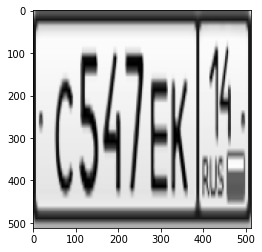

2) the_labels (pill imprint): C547EK1400000000000000000000000000000000 is encoded as [12, 5, 4, 7, 13, 15, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3) input_length (width of image that is fed to the loss function): 126 == 512 / 4 - 2
4) label_length (length of pill imprint): 8


In [52]:
for inp, out in tiger.next_batch():
    print('Text generator output (data which will be fed into the neutral network):')
    print('1) the_input (image)')
    if K.image_data_format() == 'channels_first':
        img = inp['the_input'][0, 0, :, :]
    else:
        img = inp['the_input'][0, :, :, 0]
    
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('2) the_labels (pill imprint): %s is encoded as %s' % 
          (labels_to_text(inp['the_labels'][0], tiger.max_text_len), list(map(int, inp['the_labels'][0]))))
    print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
          (inp['input_length'][0], tiger.img_w))
    print('4) label_length (length of pill imprint): %d' % inp['label_length'][0])
    break

# Loss and train functions, network architecture

In [55]:
def load_model_json():
    # load json and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("tmp_model.h5")
    print("Loaded model from disk")
    return loaded_model

In [56]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def train(img_w, load=False):
    # Input Parameters
    img_h = img_w

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        
    batch_size = 32
    downsample_factor = pool_size ** 2
    tiger_train = TextImageGenerator('../data/anpr_ocr__train', 'train', img_w, img_h, batch_size, downsample_factor)
    tiger_train.build_data()
    tiger_val = TextImageGenerator('../data/anpr_ocr__train', 'val', img_w, img_h, batch_size, downsample_factor)
    tiger_val.build_data()

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    if load:
#         model = load_model('./tmp_model.h5', compile=False)
        model = load_model_json()
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if not load:
        # captures output of softmax so we can decode the output during visualization
        test_func = K.function([input_data], [y_pred])

        model.fit_generator(generator=tiger_train.next_batch(), 
                            steps_per_epoch=tiger_train.n,
                            epochs=1, 
                            validation_data=tiger_val.next_batch(), 
                            validation_steps=tiger_val.n)

    return model

# Model description and training

Next block will take about 30 minutes.

In [ ]:
load = True

In [33]:
model = train(pill_dim, load=load)
if not load:
    # serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("tmp_model.h5")
    print("Saved model to disk")

self.n 10248
self.n 573
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 16) 160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 256, 256, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 256, 256, 16) 2320        max1[0][0]                       
_____________

# Function to decode neural network output

In [59]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

In [60]:
# tiger_test = TextImageGenerator('../data/anpr_ocr__test', 'test', pill_dim, pill_div, 8, 4)

# Test on validation images

In [66]:
tiger_test = TextImageGenerator('../data/anpr_ocr__test', 'test', pill_dim, pill_dim, 8, 4)
tiger_test.build_data()

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output



self.n 561


In [ ]:
for inp_value, _ in tiger_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    match = 0
    unmatch = 0
    j = 0
    for i in range(bs):
#         fig = plt.figure(figsize=(10, 10))
#         outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
#         ax1 = plt.Subplot(fig, outer[0])
#         fig.add_subplot(ax1)
#         ax2 = plt.Subplot(fig, outer[1])
#         fig.add_subplot(ax2)
#         print('Predicted: %s\nTrue: %s' % (pred_texts[i] , texts[i][0:len(pred_texts[i])]))
        if pred_texts[i] == texts[i][0:len(pred_texts[i])]:
            match += 1
        else:
            unmatch += 1
#         img = X_data[i][:, :, 0].T
#         ax1.set_title('Input img')
#         ax1.imshow(img, cmap='gray')
#         ax1.set_xticks([])
#         ax1.set_yticks([])
#         ax2.set_title('Activations')
#         ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
#         ax2.set_yticks(list(range(len(letters) + 1)))
#         ax2.set_yticklabels(letters + ['blank'])
#         ax2.grid(False)
#         for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
#             ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
#         #ax.axvline(x, linestyle='--', color='k')
#         plt.show()
        j += 1
#         if j == 10:
#             break
print(match,unmatch)
